In [46]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.patches import Patch, Circle

import warnings
warnings.filterwarnings("ignore")

In [47]:
def get_state_code(state_name):
    """
    Returns the code for a given state name.

    Parameters:
        state_name (str): The name of the state (case insensitive).

    Returns:
        str: The state code if found, otherwise 'State not found'.
    """
    state_codes = {
        "ALABAMA": "01",
        "ALASKA": "02",
        "ARIZONA": "04",
        "ARKANSAS": "05",
        "CALIFORNIA": "06",
        "COLORADO": "08",
        "CONNECTICUT": "09",
        "DELAWARE": "10",
        "DISTRICT OF COLUMBIA": "11",
        "FLORIDA": "12",
        "GEORGIA": "13",
        "HAWAII": "15",
        "IDAHO": "16",
        "ILLINOIS": "17",
        "INDIANA": "18",
        "IOWA": "19",
        "KANSAS": "20",
        "KENTUCKY": "21",
        "LOUISIANA": "22",
        "MAINE": "23",
        "MARYLAND": "24",
        "MASSACHUSETTS": "25",
        "MICHIGAN": "26",
        "MINNESOTA": "27",
        "MISSISSIPPI": "28",
        "MISSOURI": "29",
        "MONTANA": "30",
        "NEBRASKA": "31",
        "NEVADA": "32",
        "NEW HAMPSHIRE": "33",
        "NEW JERSEY": "34",
        "NEW MEXICO": "35",
        "NEW YORK": "36",
        "NORTH CAROLINA": "37",
        "NORTH DAKOTA": "38",
        "OHIO": "39",
        "OKLAHOMA": "40",
        "OREGON": "41",
        "PENNSYLVANIA": "42",
        "RHODE ISLAND": "44",
        "SOUTH CAROLINA": "45",
        "SOUTH DAKOTA": "46",
        "TENNESSEE": "47",
        "TEXAS": "48",
        "UTAH": "49",
        "VERMONT": "50",
        "VIRGINIA": "51",
        "WASHINGTON": "53",
        "WEST VIRGINIA": "54",
        "WISCONSIN": "55",
        "WYOMING": "56"
    }
    
    state_name = state_name.upper()
    return state_codes.get(state_name, "State not found")

## Visualize Country

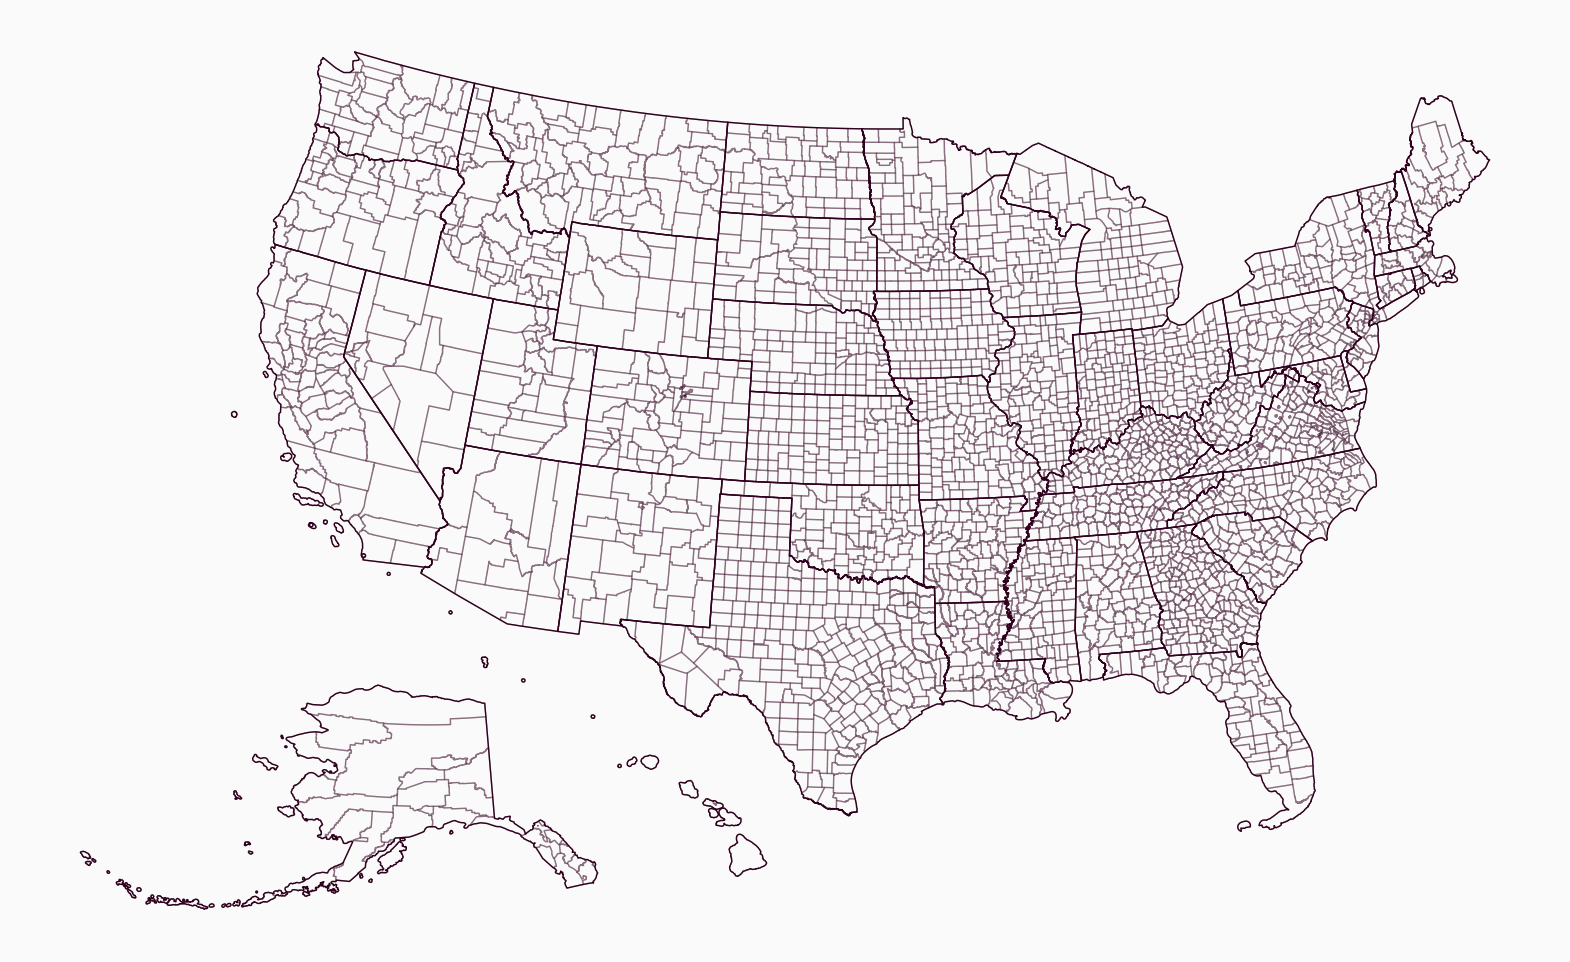

In [49]:
edge_color = "#30011E"
background_color = "#fafafa"

sns.set_style({
    "font.family": "serif",
    "figure.facecolor": background_color,
    "axes.facecolor": background_color,
})

# Load and prepare geo-data, remove states we don't care about
counties = gpd.read_file("C:/Users/ellio/python/MTHE493-5/data/map_data/tl_2024_us_county/")
counties = counties[~counties.STATEFP.isin(["72", "69", "60", "66", "78"])]
counties = counties.set_index("GEOID")

states = gpd.read_file("C:/Users/ellio/python/MTHE493-5/data/map_data/tl_2024_us_state/")
states = states[~states.STATEFP.isin(["72", "69", "60", "66", "78"])]



def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]

    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

counties = counties.to_crs("ESRI:102003")
states = states.to_crs("ESRI:102003")

counties = adjust_maps(counties)
states = adjust_maps(states)

ax = counties.plot(edgecolor=edge_color + "55", color="None", figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)

plt.axis("off")
plt.show()


## Visualize State

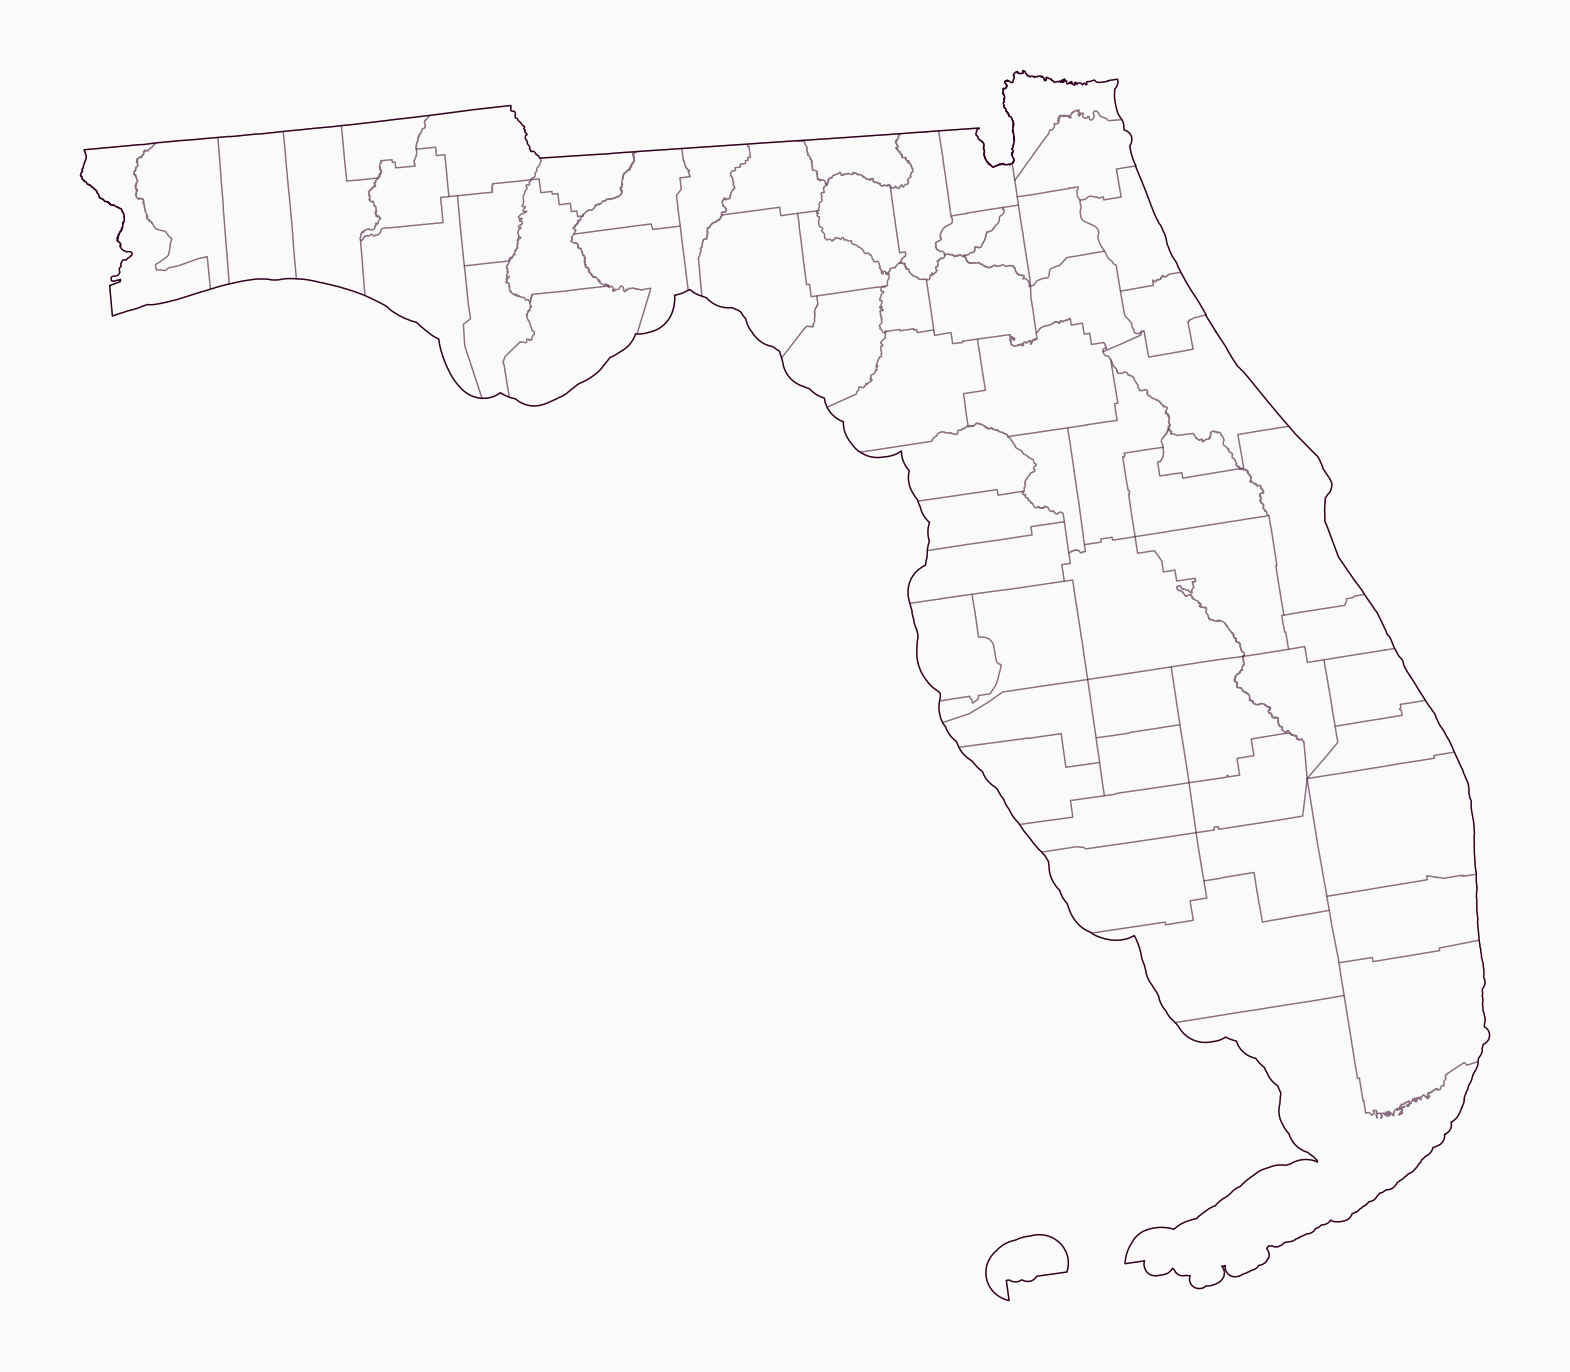

In [64]:
edge_color = "#30011E"
background_color = "#fafafa"

states_of_choice = [get_state_code(s) for s in ["Florida"]]

sns.set_style({
    "font.family": "serif",
    "figure.facecolor": background_color,
    "axes.facecolor": background_color,
})

# Load and prepare geo-data, remove states we don't care about
counties = gpd.read_file("C:/Users/ellio/python/MTHE493-5/data/map_data/tl_2024_us_county/")
counties = counties[counties.STATEFP.isin(states_of_choice)]
counties = counties.set_index("GEOID")

states = gpd.read_file("C:/Users/ellio/python/MTHE493-5/data/map_data/tl_2024_us_state/")
states = states[states.STATEFP.isin(states_of_choice)]

counties = counties.to_crs("ESRI:102003")
states = states.to_crs("ESRI:102003")

ax = counties.plot(edgecolor=edge_color + "55", color="None", figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)

plt.axis("off")
plt.show()


In [77]:
xx = counties.head(10)

for i, row in xx.iterrows():
    print(row['STATEFP']+row['COUNTYFP'])

12053
12129
12131
12127
12051
12095
12011
12099
12041
12086


Add color


In [ ]:
data_breaks = [
    (0.90, "#800000", "Top 10% (90-100%)"),   # Dark red
    (0.70, "#d32f2f", "70-90%"),              # Medium red
    (0.55, "#ffa07a", "55-70%"),              # Light red
    (0.45, "#d3d3d3", "45-55%"),              # Grey (middle range)
    (0.30, "#87ceeb", "30-45%"),              # Light blue
    (0.10, "#4682b4", "10-30%"),              # Medium blue
    (0.0,  "#00008b", "Bottom 10% (0-10%)")   # Dark blue
]

import random

def create_color(county_df, data_breaks):
    colors = []

    for i, row in county_df.iterrows():
        for p, c, _ in data_breaks:
            if random.uniform(0,1) >= p:
                colors.append(c)
                break

    return colors

##Annotations

def add_title(county_id, county_name):
    plt.annotate(
        text="Social Connectedness Ranking Between US Counties and",
        xy=(0.5, 1.1), xycoords="axes fraction", fontsize=16, ha="center"
    )

    plt.annotate(
        text="{} (FIPS Code {})".format(county_name, county_id), 
        xy=(0.5, 1.03), xycoords="axes fraction", fontsize=32, ha="center",
        fontweight="bold"
    )

def add_legend(data_breaks, selected_color, county_name):
    patches = [Patch(facecolor=c, edgecolor=edge_color, label=t) for _, c, t in data_breaks]
    patches = [Patch(facecolor=selected_color, edgecolor=edge_color, label=county_name)] + patches

    leg = plt.legend(
        handles=patches,
        bbox_to_anchor=(0.5, -0.03), loc='center',
        ncol=10, fontsize=20, columnspacing=1,
        handlelength=1, handleheight=1,
        edgecolor=background_color,
        handletextpad=0.4
    )

def add_information():
    plt.annotate(
        "The Facebook Connectivity Index measure the likelyhood that users in different\nlocations are connected on Facebook. The formula divides the number of Facebook\nconnections with the number of possible connections for the two locations.",
        xy=(0.5, -0.08), xycoords="axes fraction", ha="center", va="top", fontsize=18, linespacing=1.8
    )

    plt.annotate(
        "Source: https://dataforgood.facebook.com/", 
        xy=(0.5, -0.22), xycoords="axes fraction", fontsize=16, ha="center",
        fontweight="bold"
    )

def add_circle(ax, counties_df, county_id):
    center = counties_df[counties_df.index == county_id].geometry.centroid.iloc[0]
    ax.add_artist(
        Circle(
            radius=100000, xy=(center.x, center.y), facecolor="None", edgecolor=selected_color, linewidth=4
        )
    )

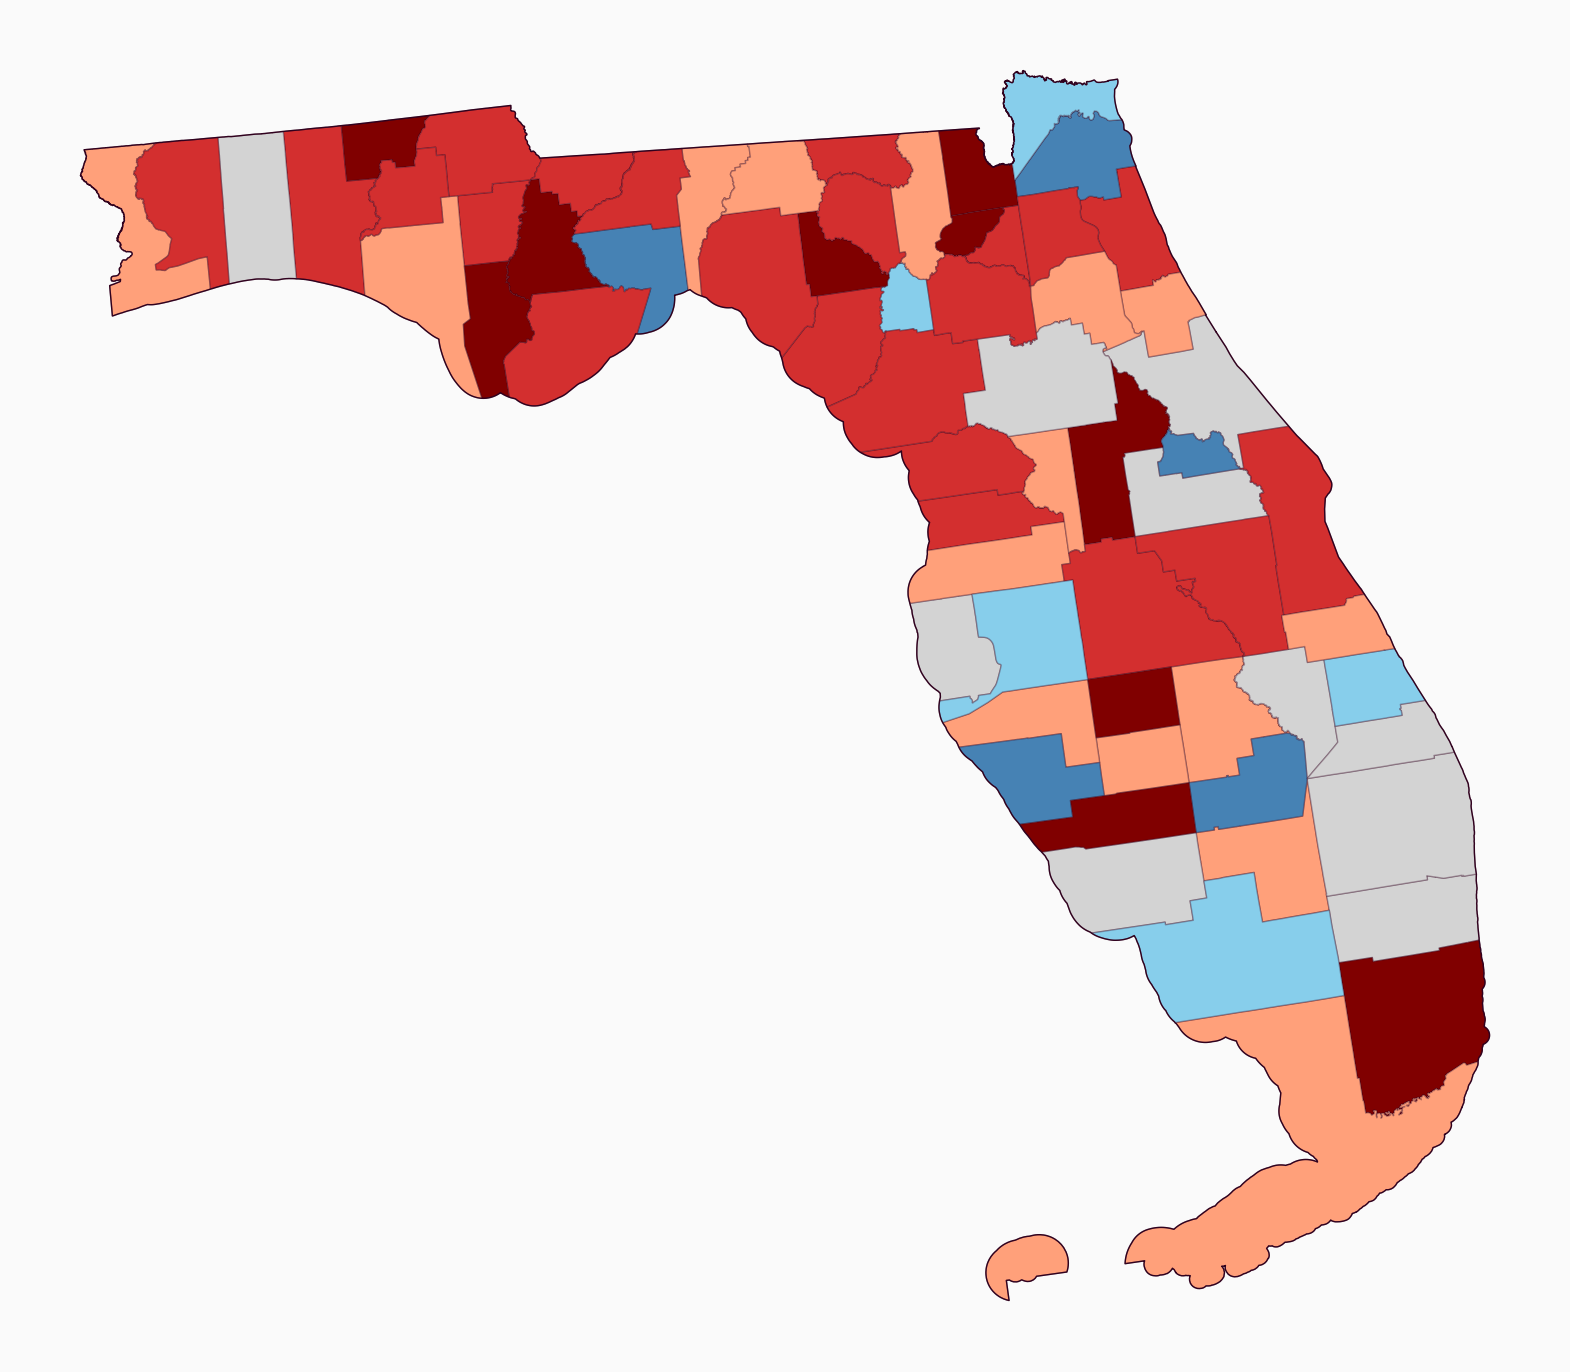

In [70]:
counties.loc[:, "color"] = create_color(counties, data_breaks)

ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)
#ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

#add_circle(ax, counties, county_id)
#add_title(county_id, county_name)
#add_legend(data_breaks, selected_color, county_name)
#add_information()

plt.axis("off")
plt.show()

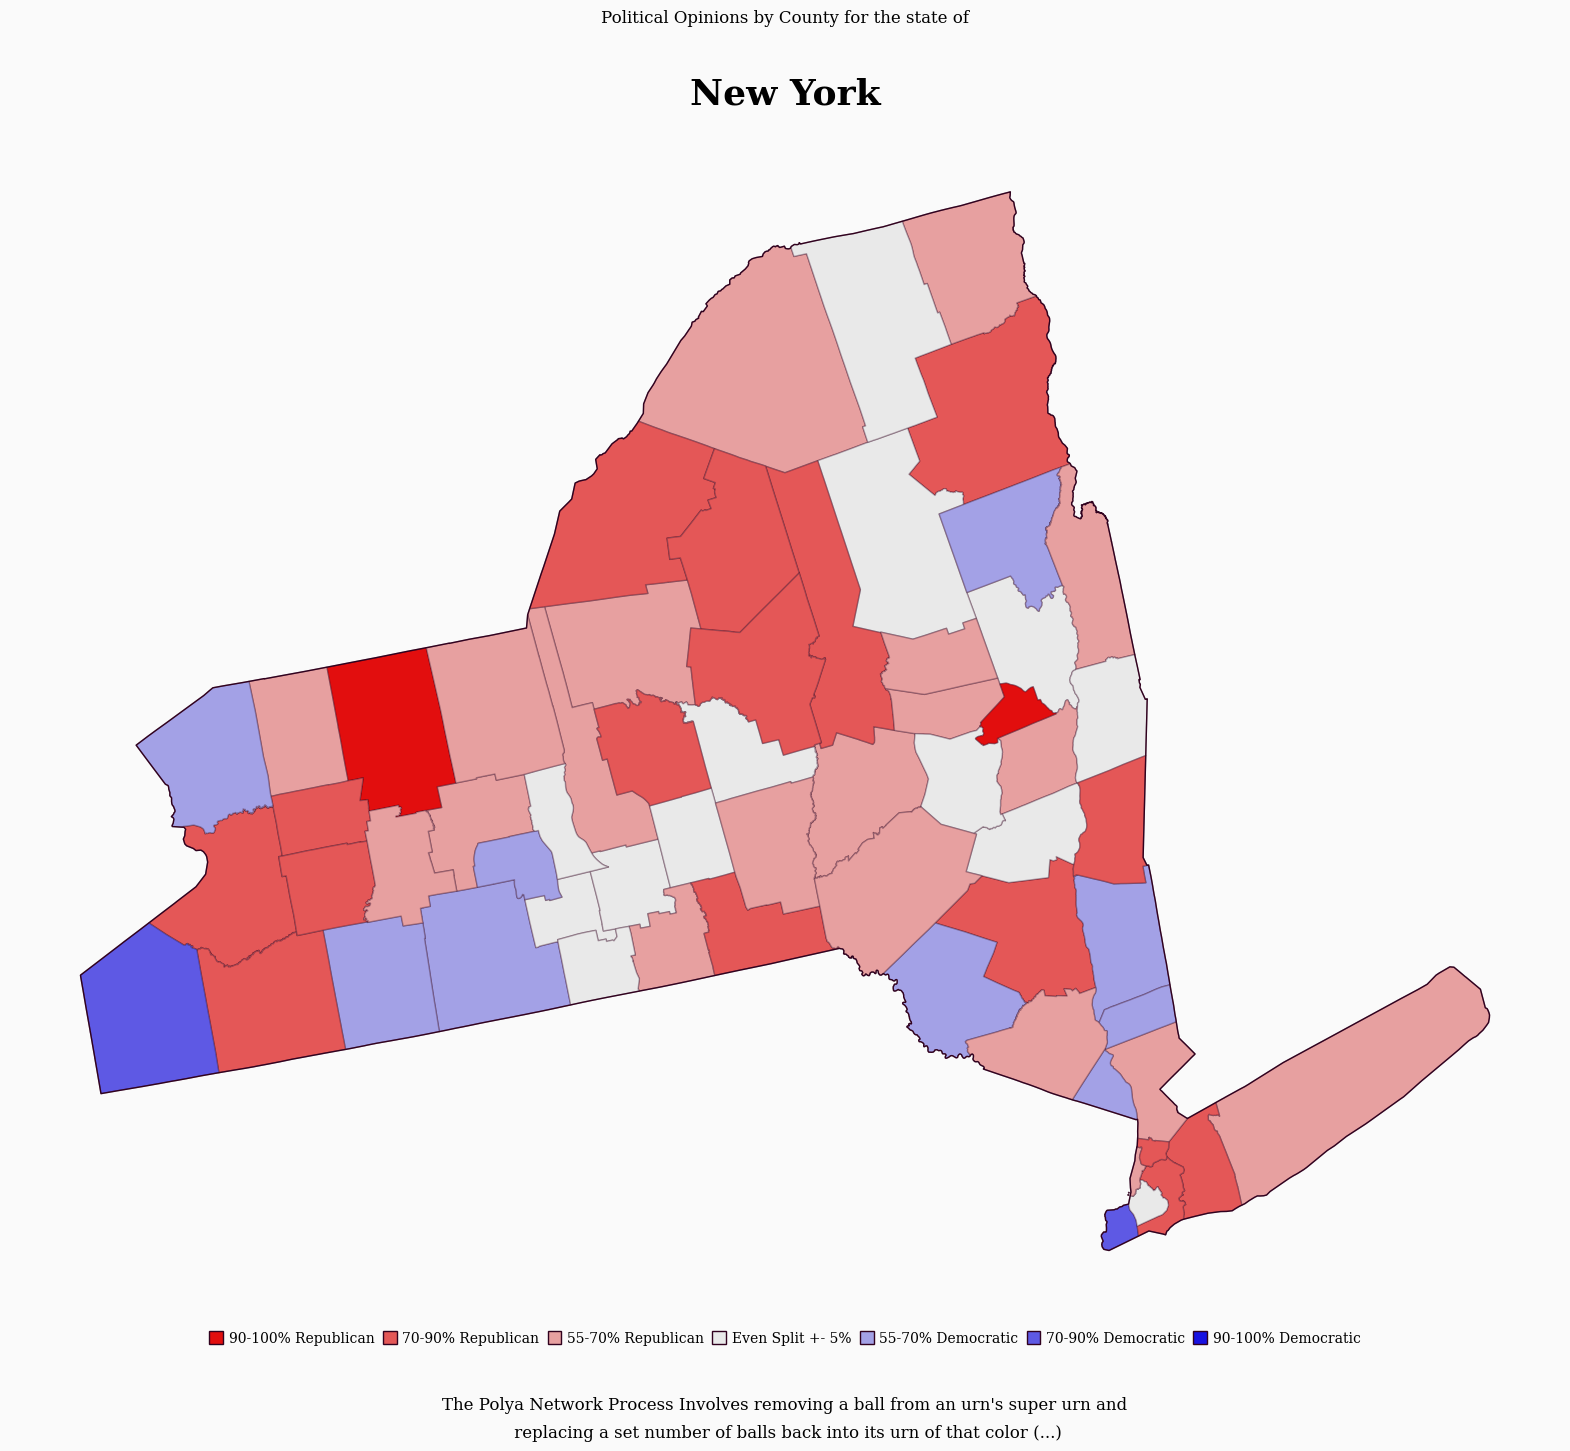

In [71]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.patches import Patch, Circle

import warnings
warnings.filterwarnings("ignore")
import random

def get_state_code(state_name):
    """
    Returns the code for a given state name.

    Parameters:
        state_name (str): The name of the state (case insensitive).

    Returns:
        str: The state code if found, otherwise 'State not found'.
    """
    state_codes = {
        "ALABAMA": "01",
        "ALASKA": "02",
        "ARIZONA": "04",
        "ARKANSAS": "05",
        "CALIFORNIA": "06",
        "COLORADO": "08",
        "CONNECTICUT": "09",
        "DELAWARE": "10",
        "DISTRICT OF COLUMBIA": "11",
        "FLORIDA": "12",
        "GEORGIA": "13",
        "HAWAII": "15",
        "IDAHO": "16",
        "ILLINOIS": "17",
        "INDIANA": "18",
        "IOWA": "19",
        "KANSAS": "20",
        "KENTUCKY": "21",
        "LOUISIANA": "22",
        "MAINE": "23",
        "MARYLAND": "24",
        "MASSACHUSETTS": "25",
        "MICHIGAN": "26",
        "MINNESOTA": "27",
        "MISSISSIPPI": "28",
        "MISSOURI": "29",
        "MONTANA": "30",
        "NEBRASKA": "31",
        "NEVADA": "32",
        "NEW HAMPSHIRE": "33",
        "NEW JERSEY": "34",
        "NEW MEXICO": "35",
        "NEW YORK": "36",
        "NORTH CAROLINA": "37",
        "NORTH DAKOTA": "38",
        "OHIO": "39",
        "OKLAHOMA": "40",
        "OREGON": "41",
        "PENNSYLVANIA": "42",
        "RHODE ISLAND": "44",
        "SOUTH CAROLINA": "45",
        "SOUTH DAKOTA": "46",
        "TENNESSEE": "47",
        "TEXAS": "48",
        "UTAH": "49",
        "VERMONT": "50",
        "VIRGINIA": "51",
        "WASHINGTON": "53",
        "WEST VIRGINIA": "54",
        "WISCONSIN": "55",
        "WYOMING": "56"
    }
    
    state_name = state_name.upper()
    return state_codes.get(state_name, "State not found")


def visualize_state_opinions(state_names):
    #start of code!!

    edge_color = "#30011E"
    background_color = "#fafafa"

    data_breaks = [
        (0.90, "#E20E0E", "90-100% Republican"),   # Dark red
        (0.70, "#E45757", "70-90% Republican"),              # Medium red
        (0.55, "#E7A0A0", "55-70% Republican"),              # Light red
        (0.45, "#E9E9E9", "Even Split +- 5%"),              # Grey (middle range)
        (0.30, "#A3A1E6", "55-70% Democratic"),              # Light blue
        (0.10, "#5E59E4", "70-90% Democratic"),              # Medium blue
        (0.0,  "#1811E1", "90-100% Democratic")   # Dark blue
    ]

    def create_color(county_df, data_breaks):
        colors = []

        for i, row in county_df.iterrows():
            for p, c, _ in data_breaks:
                if random.uniform(0,1) >= p:
                    colors.append(c)
                    break
        return colors

    def add_title(state_names):
        if len(state_names) == 1:
            plt.annotate(
                text="Political Opinions by County for the state of",
                xy=(0.5, 1.1), xycoords="axes fraction", fontsize=12, ha="center"
            )

            plt.annotate(
                text=f"{state_names[0]}", 
                xy=(0.5, 1.03), xycoords="axes fraction", fontsize=26, ha="center",
                fontweight="bold"
            )

        elif len(state_names) > 1:
            plt.annotate(
                text="Political Opinions by County for the states of",
                xy=(0.5, 1.1), xycoords="axes fraction", fontsize=12, ha="center"
            )
            text = ""
            for i in range(len(state_names)-1):
                text = text + state_names[i] + ", "
            text = text + state_names[len(state_names)-1]
            plt.annotate(
                text=text,
                xy=(0.5, 1.03), xycoords="axes fraction", fontsize=26, ha="center",
                fontweight="bold"
            )
    
    def add_legend(data_breaks):
        patches = [Patch(facecolor=c, edgecolor=edge_color, label=t) for _, c, t in data_breaks]

        leg = plt.legend(
            handles=patches,
            bbox_to_anchor=(0.5, -0.03), loc='center',
            ncol=10, fontsize=10, columnspacing=0.6,
            handlelength=1, handleheight=1,
            edgecolor=background_color,
            handletextpad=0.4
        )

    def add_information():
        plt.annotate(
            "The Polya Network Process Involves removing a ball from an urn's super urn and\n replacing a set number of balls back into its urn of that color (...)",
            xy=(0.5, -0.08), xycoords="axes fraction", ha="center", va="top", fontsize=12, linespacing=1.8
        )

        # plt.annotate(
        #     "Source: https://dataforgood.facebook.com/", 
        #     xy=(0.5, -0.22), xycoords="axes fraction", fontsize=16, ha="center",
        #     fontweight="bold"
        # )

    sns.set_style({
        "font.family": "serif",
        "figure.facecolor": background_color,
        "axes.facecolor": background_color,
    })

    state_codes = [get_state_code(s) for s in state_names]

    # Load and prepare geo-data, remove states we don't care about
    counties = gpd.read_file("C:/Users/ellio/python/MTHE493-5/data/map_data/tl_2024_us_county/")
    counties = counties[counties.STATEFP.isin(state_codes)]
    counties = counties.set_index("GEOID")

    states = gpd.read_file("C:/Users/ellio/python/MTHE493-5/data/map_data/tl_2024_us_state/")
    states = states[states.STATEFP.isin(state_codes)]

    counties = counties.to_crs("ESRI:102003")
    states = states.to_crs("ESRI:102003")

    counties.loc[:, "color"] = create_color(counties, data_breaks)
    ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
    states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)

    add_title(state_names)
    add_legend(data_breaks)
    add_information()

    plt.axis("off")
    plt.show()

visualize_state_opinions(["New York"])